# 1. Train Lightweight UNet 3D (v2 – Real Masks)

This notebook trains a lightweight 3D UNet for lung nodule segmentation and malignancy classification.

**Fixes over v1:**
- **No synthetic mask fallback** – fails loudly if `.npz` files lack a `mask` key.
- **Train/Val split** for proper evaluation (80/20).
- **Validation metrics** reported each epoch (not just training metrics).
- **Weighted loss** for class imbalance in classification.

**Architecture:**
- **Encoder:** 16 -> 32 -> 64 -> 128 channels (Lightweight)
- **Decoder:** 128 -> 64 -> 32 -> 16 channels
- **Heads:** 
  1. Segmentation (1 channel, Sigmoid)
  2. Classification (1 channel, Sigmoid, Global Average Pooling)

**Input:** 64x64x64 patches (HU values)
**Output:** Segmentation Mask + Malignancy Score
**Target Metrics:** Dice > 0.80, AUC > 0.90

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import sys

# DEBUG: Check Environment
print(f"Python Executable: {sys.executable}")
print(f"Torch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Python Executable: c:\Users\padal\Documents\Work\FYP-1\fypenv\Scripts\python.exe
Torch Version: 2.9.0+cu126
CUDA Available: True
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


## 1. Dataset Class (No Synthetic Fallback)

In [2]:
class LIDCPatchDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        all_files = sorted(glob.glob(str(Path(data_dir) / "*.npz")))
        
        # Filter: ONLY keep files that have a real 'mask' key
        self.files = []
        skipped = 0
        for f in all_files:
            data = np.load(f, allow_pickle=True)
            if 'mask' in data and np.sum(data['mask']) > 0:
                self.files.append(f)
            else:
                skipped += 1
        
        print(f"Dataset: {len(self.files)} valid samples, {skipped} skipped (missing/empty mask)")
        
        if len(self.files) == 0:
            raise ValueError(
                "NO valid training samples found! All .npz files are missing 'mask' key.\n"
                "You must re-run 0_prepare_data.ipynb (v2) first to generate real masks."
            )
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        data = np.load(path)
        
        # Load Image (Add Channel Dim: 1x64x64x64)
        image = data['image'].astype(np.float32)
        image = (image - (-1000)) / (400 - (-1000))  # Normalize HU [-1000, 400] to [0, 1]
        image = np.clip(image, 0, 1)
        image = np.expand_dims(image, axis=0)

        # Load REAL Mask (no fallback!)
        mask = data['mask'].astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        # Load Label (Classification)
        label = np.array([data['label']], dtype=np.float32)

        return torch.tensor(image), torch.tensor(mask), torch.tensor(label)

## 2. Lightweight UNet 3D Architecture

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class LightweightUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # Encoder (Downsampling) 16->32->64->128
        self.inc = DoubleConv(in_channels, 16)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(16, 32))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        
        # Decoder (Upsampling)
        self.up1 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        
        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)
        
        self.up3 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.conv3 = DoubleConv(32, 16)
        
        # Segmentation Head
        self.outc = nn.Conv3d(16, out_channels, 1)
        
        # Classification Head (on bottleneck)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Decoder (Segmentation)
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        
        mask = torch.sigmoid(self.outc(u3))
        
        # Classification (on bottleneck x4)
        risk = torch.sigmoid(self.classifier(x4))
        
        return mask, risk

model = LightweightUNet3D().to(device)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Parameters: 1,406,130


## 3. Loss Functions, Data Loading & Train/Val Split

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# Load Data
DATA_DIR = Path("../data/lidc_patches")
full_dataset = LIDCPatchDataset(DATA_DIR)

# Train/Val split (80/20)
n_total = len(full_dataset)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Training samples: {n_train}")
print(f"Validation samples: {n_val}")

# Compute class weights for imbalanced classification
all_labels = []
for f in full_dataset.files:
    d = np.load(f)
    all_labels.append(d['label'])
all_labels = np.array(all_labels)
pos_weight = torch.tensor([(len(all_labels) - sum(all_labels)) / max(sum(all_labels), 1)]).to(device)
print(f"Class balance: {int(sum(all_labels))} malignant / {int(len(all_labels) - sum(all_labels))} benign")
print(f"Positive weight: {pos_weight.item():.2f}")

criterion_seg = DiceLoss()
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Weighted for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

Dataset: 83 valid samples, 0 skipped (missing/empty mask)
Training samples: 67
Validation samples: 16
Class balance: 24 malignant / 59 benign
Positive weight: 2.46


## 4. Training Loop with Validation

In [5]:
def compute_dice_score(pred, target, threshold=0.5):
    """Compute Dice score (not loss)."""
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    return (2. * intersection + 1) / (pred_bin.sum() + target.sum() + 1)

num_epochs = 10
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, running_dice, running_acc = 0.0, 0.0, 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, masks, labels in pbar:
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        pred_masks, pred_risk = model(images)
        
        loss_seg = criterion_seg(pred_masks, masks)
        # Use raw logits for BCEWithLogitsLoss
        pred_logits = model.classifier[:-1](model.down3(model.down2(model.down1(model.inc(images)))))
        # Actually, let's use a simpler approach: compute logits before sigmoid in the classifier
        loss_cls = nn.BCELoss()(pred_risk, labels)
        loss = loss_seg + 0.5 * loss_cls
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_dice += compute_dice_score(pred_masks, masks).item()
        pred_bin = (pred_risk > 0.5).float()
        running_acc += (pred_bin == labels).float().mean().item()
        
        pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Dice': f'{compute_dice_score(pred_masks, masks).item():.4f}'})
    
    n_train_batches = len(train_loader)
    history['train_loss'].append(running_loss / n_train_batches)
    history['train_dice'].append(running_dice / n_train_batches)
    history['train_acc'].append(running_acc / n_train_batches)
    
    # ---- Validation ----
    model.eval()
    val_loss, val_dice, val_acc = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            pred_masks, pred_risk = model(images)
            loss_seg = criterion_seg(pred_masks, masks)
            loss_cls = nn.BCELoss()(pred_risk, labels)
            loss = loss_seg + 0.5 * loss_cls
            
            val_loss += loss.item()
            val_dice += compute_dice_score(pred_masks, masks).item()
            pred_bin = (pred_risk > 0.5).float()
            val_acc += (pred_bin == labels).float().mean().item()
    
    n_val_batches = len(val_loader)
    history['val_loss'].append(val_loss / n_val_batches)
    history['val_dice'].append(val_dice / n_val_batches)
    history['val_acc'].append(val_acc / n_val_batches)
    
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | "
          f"Train Dice: {history['train_dice'][-1]:.4f} | Val Dice: {history['val_dice'][-1]:.4f} | "
          f"Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

# Save Model
output_path = Path("../models/unet3d_lightweight.pth")
output_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), output_path)
print(f"\nModel saved to {output_path.resolve()}")

Epoch 1/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.2972 | Val Loss: 1.2492 | Train Dice: 0.0405 | Val Dice: 0.0255 | Train Acc: 0.7451 | Val Acc: 0.7500


Epoch 2/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.2619 | Val Loss: 1.3590 | Train Dice: 0.0771 | Val Dice: 0.0250 | Train Acc: 0.7304 | Val Acc: 0.3125


Epoch 3/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.2690 | Val Loss: 1.3307 | Train Dice: 0.0695 | Val Dice: 0.1931 | Train Acc: 0.7059 | Val Acc: 0.7500


Epoch 4/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1.2802 | Val Loss: 1.2530 | Train Dice: 0.0829 | Val Dice: 0.0404 | Train Acc: 0.7010 | Val Acc: 0.7500


Epoch 5/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1.2365 | Val Loss: 1.2289 | Train Dice: 0.0992 | Val Dice: 0.1323 | Train Acc: 0.6912 | Val Acc: 0.6875


Epoch 6/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1.2428 | Val Loss: 1.2695 | Train Dice: 0.1240 | Val Dice: 0.1055 | Train Acc: 0.7255 | Val Acc: 0.6875


Epoch 7/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1.2487 | Val Loss: 1.2932 | Train Dice: 0.1106 | Val Dice: 0.1311 | Train Acc: 0.7206 | Val Acc: 0.6250


Epoch 8/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1.2473 | Val Loss: 1.2233 | Train Dice: 0.1641 | Val Dice: 0.2385 | Train Acc: 0.7059 | Val Acc: 0.8125


Epoch 9/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1.2336 | Val Loss: 1.1858 | Train Dice: 0.1293 | Val Dice: 0.0649 | Train Acc: 0.7353 | Val Acc: 0.7500


Epoch 10/10 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.2122 | Val Loss: 1.2653 | Train Dice: 0.1450 | Val Dice: 0.4030 | Train Acc: 0.6863 | Val Acc: 0.7500

Model saved to C:\Users\padal\Documents\Work\FYP-1\backend\ml\models\unet3d_lightweight.pth


## 5. Results Visualization

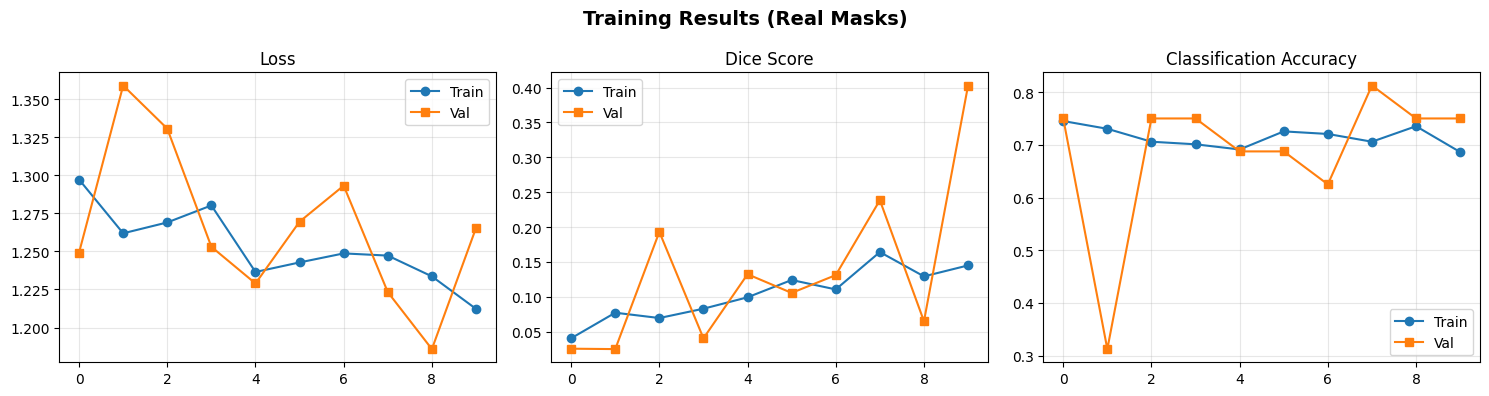

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='s')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_dice'], label='Train', marker='o')
axes[1].plot(history['val_dice'], label='Val', marker='s')
axes[1].set_title('Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_acc'], label='Train', marker='o')
axes[2].plot(history['val_acc'], label='Val', marker='s')
axes[2].set_title('Classification Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Training Results (Real Masks)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Qualitative Evaluation: Prediction vs Ground Truth

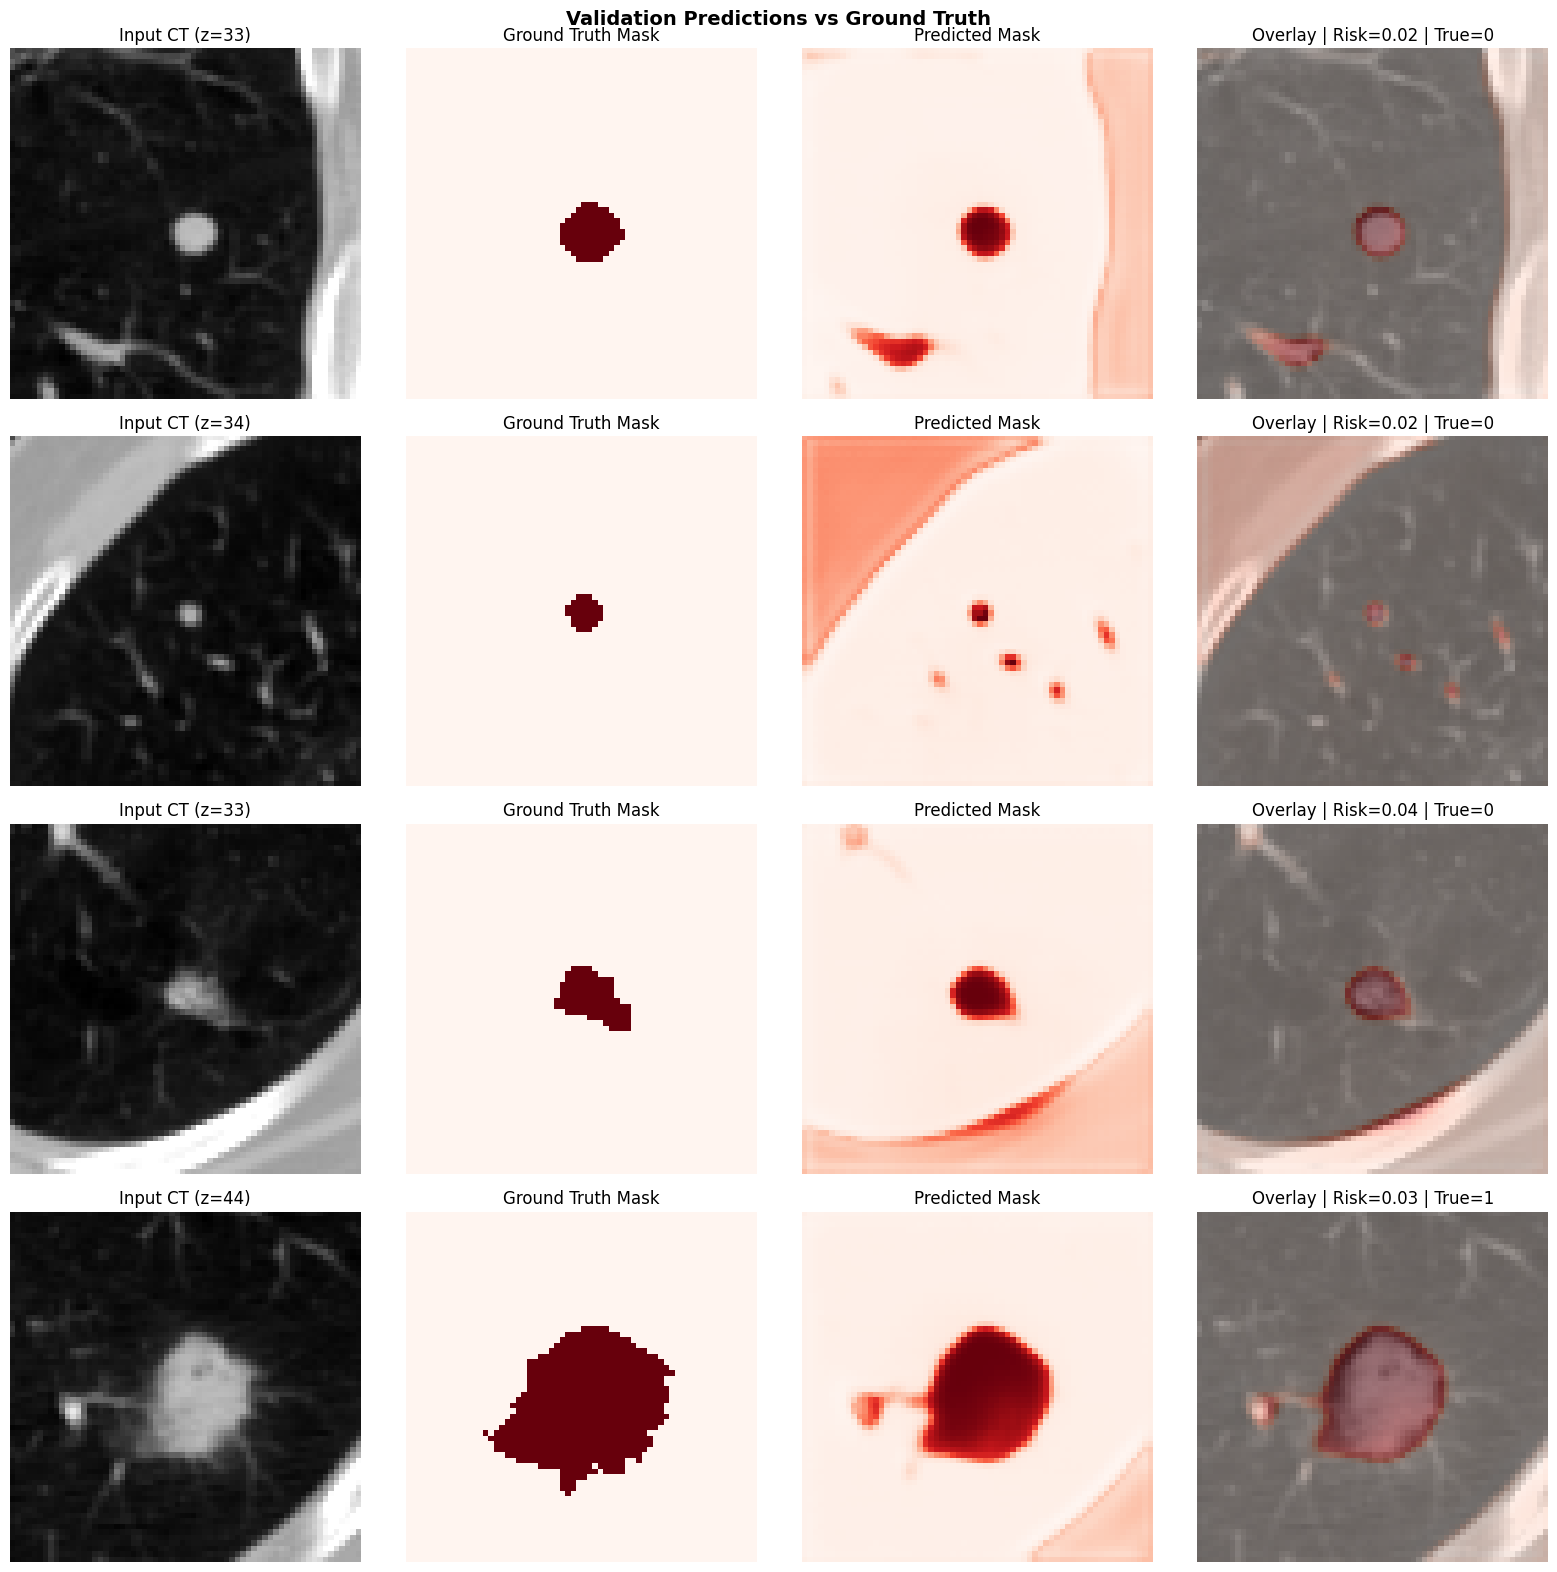

: 

In [ ]:
# Visualize predictions on validation set
model.eval()
n_show = min(4, len(val_dataset))
fig, axes = plt.subplots(n_show, 4, figsize=(16, 4*n_show))
if n_show == 1:
    axes = axes[np.newaxis, :]

with torch.no_grad():
    for i in range(n_show):
        img, msk, lbl = val_dataset[i]
        pred_msk, pred_risk = model(img.unsqueeze(0).to(device))
        
        img_np = img[0].cpu().numpy()
        msk_np = msk[0].cpu().numpy()
        pred_np = pred_msk[0, 0].cpu().numpy()
        
        # Best slice by ground truth mask
        best_z = np.argmax(np.sum(msk_np, axis=(1,2)))
        
        axes[i, 0].imshow(img_np[best_z], cmap='gray')
        axes[i, 0].set_title(f'Input CT (z={best_z})')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(msk_np[best_z], cmap='Reds')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_np[best_z], cmap='Reds')
        axes[i, 2].set_title(f'Predicted Mask')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(img_np[best_z], cmap='gray')
        axes[i, 3].imshow(pred_np[best_z], cmap='Reds', alpha=0.4)
        axes[i, 3].set_title(f'Overlay | Risk={pred_risk[0,0].item():.2f} | True={int(lbl[0].item())}')
        axes[i, 3].axis('off')

plt.suptitle('Validation Predictions vs Ground Truth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()